In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import tyssue
import sys
sys.path.append('/home/guillaume/Python/tyssue/src/py-tyssue/')
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt

from scipy import optimize

from tyssue.core.sheet import Sheet

import tyssue.geometry.sheet_geometry as geom
import tyssue.dynamics.sheet_vertex_model as model
import tyssue.solvers.sheet_vertex_solver as solver

from tyssue.draw.mpl_draw import sheet_view, default_draw_specs
from tyssue.io import hdf5

In [3]:
h5store = 'small_hexagonal.hf5'
datasets = hdf5.load_datasets(h5store, data_names=['cell', 'jv', 'je'])
sheet = Sheet('emin', datasets)

# hdf5.save_datasets('small_hexagonal.hf5', sheet)

In [4]:
sheet.je_df.head()

,,,dy,dx,dz,length,old_jv0,old_jv1,old_cell,nx,ny,nz,sub_area,line_tension
srce,trgt,cell,,,,,,,,,,,,
1,0,0,-1.857558,0.369491,-1.10053,2.190482,56,57,0,1.888686,7.823193e-01,-6.863514e-01,1.078220e+00,0.12
2,1,0,-1.574762,1.052222,1.10053,2.190482,57,58,0,0.000000,-2.220446e-16,-3.330669e-16,2.001483e-16,0.12
0,1,1,1.857558,-0.369491,1.10053,2.190482,56,57,1,4.088597,5.421817e-01,4.575676e-01,2.074847e+00,0.12
3,0,1,1.857558,0.369491,-1.10053,2.190482,56,59,1,4.088597,-5.421817e-01,4.575676e-01,2.074847e+00,0.12
1,6,1,0.000000,0.000000,2.20106,2.201060,57,62,1,4.088597,2.710909e-01,0.000000e+00,2.048787e+00,0.12


In [5]:
sheet.cell_df.describe()

,perimeter,z,x,is_alive,area,y,old_idx,basal_shift,height,vol,vol_elasticity,prefered_height,contractility,prefered_area
count,56.000000,5.600000e+01,5.600000e+01,56.000000,56.000000,5.600000e+01,56.000000,56,56.000000,56.000000,56,56,56.00,56
mean,10.654597,-3.370320e-16,-1.284687e-15,0.714286,9.163036,4.440892e-16,27.500000,4,0.651436,5.615578,1,24,0.04,10
std,4.003702,5.972802e+00,3.319195e+00,0.455842,5.159561,3.319195e+00,16.309506,0,0.069771,3.060265,0,0,0.00,0
min,4.380964,-8.253977e+00,-4.669287e+00,0.000000,1.078220,-4.669287e+00,0.000000,4,0.607705,0.820271,1,24,0.04,10
25%,4.380964,-6.603181e+00,-3.258140e+00,0.000000,1.078220,-3.258140e+00,13.750000,4,0.607705,0.820271,1,24,0.04,10
50%,13.164050,-2.590520e-16,-1.702342e-15,1.000000,12.396962,1.369275e-15,27.500000,4,0.607705,7.533701,1,24,0.04,10
75%,13.164050,6.603181e+00,3.258140e+00,1.000000,12.396962,3.258140e+00,41.250000,4,0.760764,7.533701,1,24,0.04,10
max,13.164050,8.253977e+00,4.669287e+00,1.000000,12.396962,4.669287e+00,55.000000,4,0.760764,7.533701,1,24,0.04,10


In [6]:
geom.default_params

{'basal_shift': 4.0, 'geometry': 'cylindrical', 'height_axis': 'z'}

In [7]:
geom.set_geometry_columns(sheet)
geom.update_all(sheet, coords=sheet.coords)
sheet.cell_df.describe()

,perimeter,z,x,is_alive,area,y,old_idx,basal_shift,height,vol,vol_elasticity,prefered_height,contractility,prefered_area,rho
count,56.000000,5.600000e+01,5.600000e+01,56.000000,56.000000,5.600000e+01,56.000000,56,56.000000,56.000000,56,56,56.00,56,56.000000
mean,10.654597,-3.370320e-16,-1.284687e-15,0.714286,9.163036,4.440892e-16,27.500000,4,8.651436,78.919867,1,24,0.04,10,4.651436
std,4.003702,5.972802e+00,3.319195e+00,0.455842,5.159561,3.319195e+00,16.309506,0,0.069771,44.336757,0,0,0.00,0,0.069771
min,4.380964,-8.253977e+00,-4.669287e+00,0.000000,1.078220,-4.669287e+00,0.000000,4,8.607705,9.446033,1,24,0.04,10,4.607705
25%,4.380964,-6.603181e+00,-3.258140e+00,0.000000,1.078220,-3.258140e+00,13.750000,4,8.607705,9.446033,1,24,0.04,10,4.607705
50%,13.164050,-2.590520e-16,-1.702342e-15,1.000000,12.396962,1.369275e-15,27.500000,4,8.607705,106.709400,1,24,0.04,10,4.607705
75%,13.164050,6.603181e+00,3.258140e+00,1.000000,12.396962,3.258140e+00,41.250000,4,8.760764,106.709400,1,24,0.04,10,4.760764
max,13.164050,8.253977e+00,4.669287e+00,1.000000,12.396962,4.669287e+00,55.000000,4,8.760764,106.709400,1,24,0.04,10,4.760764


In [8]:
model.default_params

{'contractility': 0.04,
 'line_tension': 0.12,
 'prefered_area': 10.0,
 'prefered_height': 24.0,
 'vol_elasticity': 1.0}

In [9]:
adim_parameters = model.default_params.copy()
model_params = model.dimentionalize(adim_parameters)
model.set_dynamic_columns(sheet, model_params)
model_params

{'contractility': 230.4,
 'line_tension': 2185.7663187083836,
 'norm_factor': 57600.0,
 'prefered_area': 10.0,
 'prefered_height': 24.0,
 'prefered_vol': 240.0,
 'vol_elasticity': 1.0}

we define the adimentional contractility $\bar\Gamma = \Gamma/K_vA_0h_0^2$ and line tension
$\bar\Lambda = \Lambda /K_v (A_0^{3/2}h_0^2)$, where $h_0$ is such that $V_0 = A_0h_0$.


In [10]:
sheet.cell_df['num_sides'] = np.bincount(sheet.e_cell_idx.get_level_values('cell'))

In [17]:

grad_err = solver.check_grad(sheet, sheet.coords)
grad_err / model_params['norm_factor']

0.58914372422909544

In [18]:
grad_i, grad_t, grad_c, grad_v = model.compute_gradient(sheet, components=True)

In [19]:
model_params['norm_factor']

57600.0

In [20]:
grad_i.head() / model_params['norm_factor']

,x,y,z
jv,,,
0,0.008611,0.010937,-0.000087
1,-0.018210,0.005801,0.058789
2,-0.001644,0.013822,-0.000087
3,-0.008775,0.016979,0.058789
4,-0.022956,0.008002,0.006670


In [21]:
from tyssue.dynamics.sheet_isotropic_model import *

In [22]:
isotropic_relax(sheet)

In [23]:
geom.scale(sheet, 2, sheet.coords+['basal_shift'])
geom.update_all(sheet)

In [24]:
sheet.je_df.head()

,,,dy,dx,dz,length,old_jv0,old_jv1,old_cell,nx,ny,nz,sub_area,line_tension
srce,trgt,cell,,,,,,,,,,,,
1,0,0,-3.440938,0.684445,-2.038621,4.057646,56,57,0,6.480800e+00,2.684435e+00,-2.355133e+00,3.699784e+00,2185.766319
2,1,0,-2.917086,1.949135,2.038621,4.057646,57,58,0,-1.776357e-15,-1.776357e-15,-8.881784e-16,1.332268e-15,2185.766319
0,1,1,3.440938,-0.684445,2.038621,4.057646,56,57,1,1.402953e+01,1.860432e+00,1.570089e+00,7.119589e+00,2185.766319
3,0,1,3.440938,0.684445,-2.038621,4.057646,56,59,1,1.402953e+01,-1.860432e+00,1.570089e+00,7.119589e+00,2185.766319
1,6,1,0.000000,0.000000,4.077241,4.077241,57,62,1,1.402953e+01,9.302159e-01,0.000000e+00,7.030169e+00,2185.766319


In [25]:
grad_i, grad_t, grad_c, grad_v = model.compute_gradient(sheet, components=True)

In [26]:
grad_i.head() / model_params['norm_factor']

,x,y,z
jv,,,
0,0.687680,-1.933695,-3.394522
1,2.368588,-1.185355,-3.403854
2,1.853592,-0.881066,-3.394522
3,0.836672,-2.513018,-3.403854
4,2.241983,-0.855219,-0.055295


In [197]:
%pdb

Automatic pdb calling has been turned OFF


In [27]:
Et, Ec, Ev = model.compute_energy(sheet, full_output=True)

0.886592687387 0.0886592687387


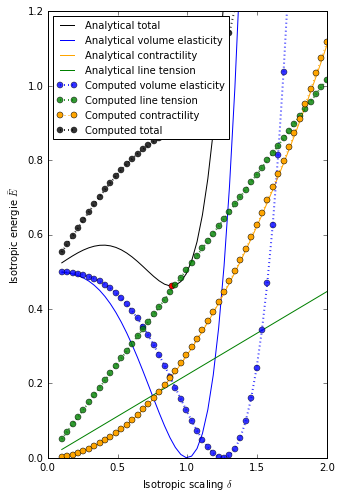

In [28]:
%matplotlib inline
deltas = np.linspace(0.1, 2, 50)
fig, ax = plt.subplots(figsize=(5, 8))
lbda = adim_parameters['line_tension']
gamma = adim_parameters['contractility']


def elasticity(delta):
    return (delta**3 - 1 )**2 / 2.

def contractility(delta, gamma):
    return gamma * mu**2 * delta**2 / 2.

def tension(delta, lbda):
    return lbda * mu * delta / 2.


ax.plot(deltas, isotropic_energy(deltas, adim_parameters), 'k-',
        label='Analytical total')
ax.plot(sheet.delta_o, isotropic_energy(sheet.delta_o, adim_parameters), 'ro')
ax.plot(deltas, elasticity(deltas), 'b-',
        label='Analytical volume elasticity')
ax.plot(deltas, contractility(deltas, gamma), color='orange', ls='-',
        label='Analytical contractility')
ax.plot(deltas, tension(deltas, lbda), 'g-',
        label='Analytical line tension')

ax.set_xlabel(r'Isotropic scaling $\delta$')
ax.set_ylabel(r'Isotropic energie $\bar E$')

area0 = model_params['prefered_area']
h_0 = model_params['prefered_height']


### Cells only area and height
area_avg = sheet.cell_df[sheet.cell_df['is_alive'] == 1].area.mean()
rho_avg = sheet.cell_df[sheet.cell_df['rho'] == 1].area.mean()

### Set height and area to height0 and area0
delta_0 = (area0 / area_avg)**0.5
geom.scale(sheet, delta_0, sheet.coords)
sheet.cell_df['basal_height'] = rho_avg * delta_0 - h_0

geom.update_all(sheet)


energy = model.compute_energy(sheet)




norm = (model_params['norm_factor'] *
        sheet.cell_df.is_alive).sum()

energies = np.zeros((deltas.size, 3))
#scales = np.linspace(0.5, 1.2, 20) / eptm.delta_o
for n, delta in enumerate(deltas):
    geom.scale(sheet, delta, sheet.coords+['basal_shift'])
    geom.update_all(sheet)

    Et, Ec, Ev = model.compute_energy(sheet, full_output=True)
    energies[n, :] = [Et.sum(), Ec.sum(), Ev.sum()]
    geom.scale(sheet, 1/delta, sheet.coords+['basal_shift'])
    geom.update_all(sheet)

isotropic_relax(sheet)


energies = energies / norm
ax.plot(deltas, energies[:, 2], 'bo:', lw=2, alpha=0.8,
        label='Computed volume elasticity')
ax.plot(deltas, energies[:, 0], 'go:', lw=2, alpha=0.8,
        label='Computed line tension')
ax.plot(deltas, energies[:, 1], ls=':',
        marker='o', color='orange', label='Computed contractility')
ax.plot(deltas, energies.sum(axis=1), 'ko:', lw=2, alpha=0.8,
        label='Computed total')

ax.legend(loc='upper left', fontsize=10)
ax.set_ylim(0, 1.2)


print(sheet.delta_o, deltas[energies.sum(axis=1).argmin()] * sheet.delta_o)

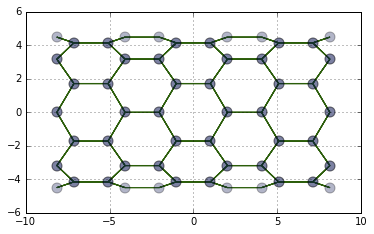

In [30]:
ax, fig = sheet_view(sheet, ['z', 'x'], draw_specs=default_draw_specs)

In [ ]:
def plot_gradients(eptm, coords, mag=10, ax=None, approx=False, ec='r', fc='r'):
    
    gcoords = ['g'+c for c in coords]
    if approx:
        app_grad = approx_grad(eptm, coords=['x', 'y', 'z'])
        grad_i = pd.DataFrame(index=eptm.jv_idx, 
                              data=app_grad.reshape((-1, 3)),
                              columns=eptm.coords) / eptm.norm_factor
        
    else:    
        grad_i = compute_gradient(eptm, components=False) / eptm.norm_factor
    
    arrows = pd.DataFrame(columns=coords + gcoords,
                          index=eptm.jv_df.index)
    
    arrows[coords] = eptm.jv_df[coords]
    arrows[gcoords] = grad_i[coords] * mag
    
    
    if ax is None:
        fig, ax = plt_eptm(eptm, coords, edge_arrow_style, points_style)
    else:
        fig = ax.get_figure()
    
    for idx, arrow in arrows.iterrows():
        x, y = coords
        gx, gy = gcoords
        ax.arrow(arrow[x], arrow[y], arrow[gx], arrow[gy],
                 ec=ec, fc=fc,
                 width=0.01,
                 alpha=0.5)
        
    return fig, ax

In [ ]:
fig, ax = plot_gradients(eptm, ['z', 'y'])
fig, ax = plot_gradients(eptm, ['z', 'y'], ax=ax, approx=True, ec='b', fc='b')

fig.set_size_inches(10, 12)


In [ ]:
eptm.je_df.line_tension = eptm.je_df.line_tension * (np.cos(eptm.je_df.nz)**2 + 0.5)

In [ ]:
eptm.je_df.head(10)

In [ ]:
fig, ax = plot_gradients(eptm, ['z', 'y'])
fig, ax = plot_gradients(eptm, ['z', 'y'], ax=ax, approx=True, ec='b', fc='b')

fig.set_size_inches(10, 12)
